#Modelo de regresión lineal
Trabajaremos en un problema de regresión, prediciendo una salida de valor real. Usaremos el conjunto de datos de ventas de casas del condado de King, WA en Kaggle. Hay alrededor de 21.000 filas con 20 funciones. El valor que intentamos predecir es un número de punto flotante etiquetado como "precio".

- Mauricio Giles Pérez 160300093 
- Joycelin Monserrat Kiau Sandoval 200300637


##Librerías a utilizar

In [ ]:
from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)


##Funciones de utilidad
Estas son las funciones auxiliares de trazado que se utilizan más adelante en el cuaderno. No necesita entender completamente lo que está pasando aquí para tener una idea general. Los nombres de las funciones se explican por sí mismos. Al principio, recomendaría omitir esta parte y pasar a la siguiente sección de Regresión logística.


In [ ]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

##Visualizacion de datos y preparación
Echemos un vistazo a las distribuciones de características.

In [ ]:
rawdf = pd.read_csv('kc_house_data.csv')
rawdf.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,"221,900.00",3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,"538,000.00",3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,"180,000.00",2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,"604,000.00",4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,"510,000.00",3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


In [ ]:
rawdf.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,"21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00"
mean,"4,580,301,520.86","540,088.14",3.37,2.11,"2,079.90","15,106.97",1.49,0.01,0.23,3.41,7.66,"1,788.39",291.51,"1,971.01",84.40,"98,077.94",47.56,-122.21,"1,986.55","12,768.46"
std,"2,876,565,571.31","367,127.20",0.93,0.77,918.44,"41,420.51",0.54,0.09,0.77,0.65,1.18,828.09,442.58,29.37,401.68,53.51,0.14,0.14,685.39,"27,304.18"
min,"1,000,102.00","75,000.00",0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,"1,900.00",0.00,"98,001.00",47.16,-122.52,399.00,651.00
25%,"2,123,049,194.00","321,950.00",3.00,1.75,"1,427.00","5,040.00",1.00,0.00,0.00,3.00,7.00,"1,190.00",0.00,"1,951.00",0.00,"98,033.00",47.47,-122.33,"1,490.00","5,100.00"
50%,"3,904,930,410.00","450,000.00",3.00,2.25,"1,910.00","7,618.00",1.50,0.00,0.00,3.00,7.00,"1,560.00",0.00,"1,975.00",0.00,"98,065.00",47.57,-122.23,"1,840.00","7,620.00"
75%,"7,308,900,445.00","645,000.00",4.00,2.50,"2,550.00","10,688.00",2.00,0.00,0.00,4.00,8.00,"2,210.00",560.00,"1,997.00",0.00,"98,118.00",47.68,-122.12,"2,360.00","10,083.00"
max,"9,900,000,190.00","7,700,000.00",33.00,8.00,"13,540.00","1,651,359.00",3.50,1.00,4.00,5.00,13.00,"9,410.00","4,820.00","2,015.00","2,015.00","98,199.00",47.78,-121.31,"6,210.00","871,200.00"


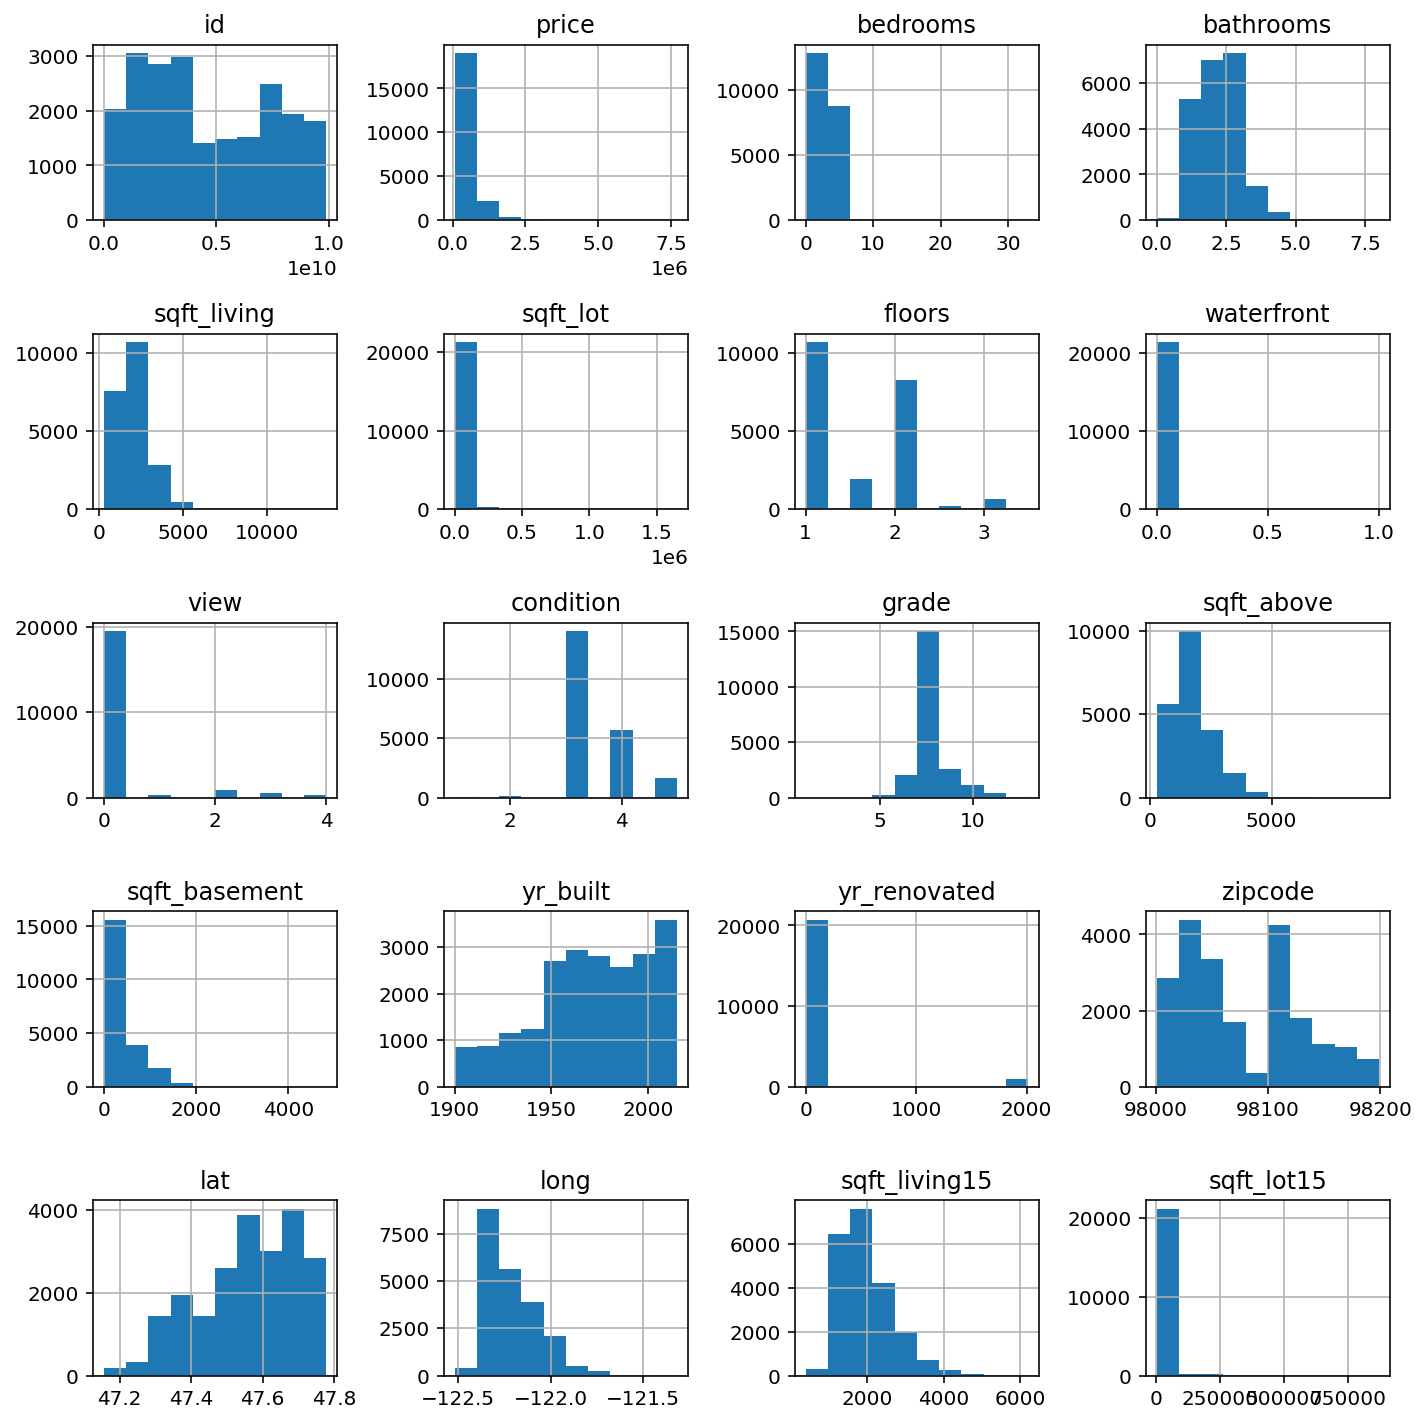

In [ ]:
rawdf.hist(figsize=(10, 10))
plt.tight_layout()

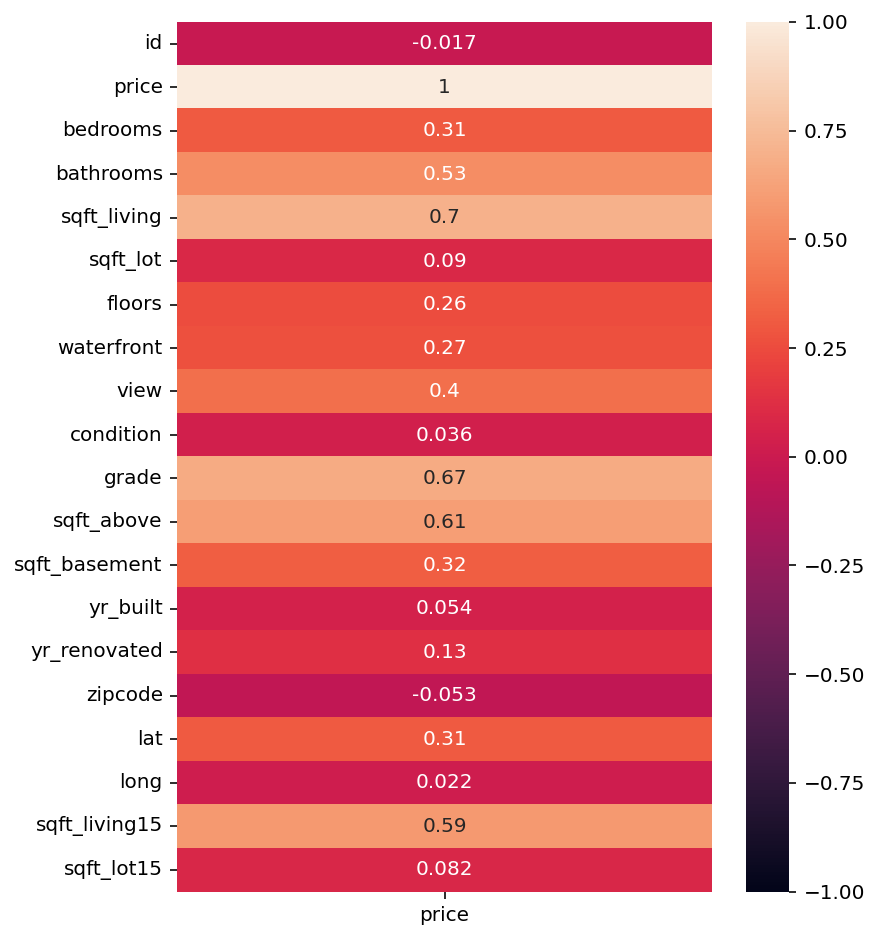

In [ ]:
plt.figure(figsize=(6, 8))
sns.heatmap(rawdf.corr()[['price']], annot=True, vmin=-1, vmax=1)

##Categorización, normalización y segmentación
- Se aplica la categorización, normalización y segmentación de código postal, pies cuadrados, años de construcción, latitud, longitud, precio y todas las variables de las casas.

In [ ]:
df = rawdf.copy()

# features that need to be scaled
ss = StandardScaler()
scale_features = ['bathrooms', 'bedrooms', 'grade', 'sqft_above', 
                  'sqft_basement', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15']
df[scale_features] = ss.fit_transform(df[scale_features])

# bucketized features
bucketized_features = ['yr_built', 'yr_renovated', 'lat', 'long']

bins = range(1890, 2021, 10)
df['yr_built'] = pd.cut(df.yr_built, bins, labels=bins[:-1])

bins = range(1930, 2021, 10)
bins = [-10] + list(bins)
df['yr_renovated'] = pd.cut(df.yr_renovated, bins, labels=bins[:-1])

bins = np.arange(47.00, 47.90, 0.05)
df['lat'] = pd.cut(df.lat, bins, labels=bins[:-1])

bins = np.arange(-122.60, -121.10, 0.05)
df['long'] = pd.cut(df.long, bins, labels=bins[:-1])

# categorical features
df['date'] = [datetime.strptime(x, '%Y%m%dT000000').strftime('%Y-%m') for x in rawdf['date'].values]
df['zipcode'] = df['zipcode'].astype('string')
categorical_features = ['zipcode', 'date']
categorical_features.extend(bucketized_features)
df_cat = pd.get_dummies(df[categorical_features])
df = df.drop(categorical_features, axis=1)
df = pd.concat([df, df_cat], axis=1)

# drop features
drop_features = ['id']
df = df.drop(drop_features, axis=1)

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,zipcode,date_2014-05,date_2014-06,date_2014-07,date_2014-08,date_2014-09,date_2014-10,date_2014-11,date_2014-12,date_2015-01,date_2015-02,date_2015-03,date_2015-04,date_2015-05,yr_built_1890,yr_built_1900,yr_built_1910,yr_built_1920,yr_built_1930,yr_built_1940,yr_built_1950,yr_built_1960,yr_built_1970,yr_built_1980,yr_built_1990,yr_built_2000,yr_built_2010,yr_renovated_-10,yr_renovated_1930,yr_renovated_1940,yr_renovated_1950,yr_renovated_1960,yr_renovated_1970,yr_renovated_1980,yr_renovated_1990,yr_renovated_2000,yr_renovated_2010,lat_47.0,lat_47.05,lat_47.099999999999994,lat_47.14999999999999,lat_47.19999999999999,lat_47.249999999999986,lat_47.29999999999998,lat_47.34999999999998,lat_47.39999999999998,lat_47.449999999999974,lat_47.49999999999997,lat_47.54999999999997,lat_47.599999999999966,lat_47.64999999999996,lat_47.69999999999996,lat_47.74999999999996,lat_47.799999999999955,long_-122.6,long_-122.55,long_-122.5,long_-122.45,long_-122.4,long_-122.35000000000001,long_-122.30000000000001,long_-122.25000000000001,long_-122.20000000000002,long_-122.15000000000002,long_-122.10000000000002,long_-122.05000000000003,long_-122.00000000000003,long_-121.95000000000003,long_-121.90000000000003,long_-121.85000000000004,long_-121.80000000000004,long_-121.75000000000004,long_-121.70000000000005,long_-121.65000000000005,long_-121.60000000000005,long_-121.55000000000005,long_-121.50000000000006,long_-121.45000000000006,long_-121.40000000000006,long_-121.35000000000007,long_-121.30000000000007,long_-121.25000000000007,long_-121.20000000000007
0,"221,900.00",-0.40,-1.45,-0.98,-0.23,1.00,0,0,3,-0.56,-0.73,-0.66,-0.94,-0.26,98178,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"538,000.00",-0.40,0.18,0.53,-0.19,2.00,0,0,3,-0.56,0.46,0.25,-0.43,-0.19,98125,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"180,000.00",-1.47,-1.45,-1.43,-0.12,1.00,0,0,3,-1.41,-1.23,-0.66,1.07,-0.17,98028,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"604,000.00",0.68,1.15,-0.13,-0.24,1.00,0,0,5,-0.56,-0.89,1.40,-0.91,-0.28,98136,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"510,000.00",-0.40,-0.15,-0.44,-0.17,1.00,0,0,3,0.29,-0.13,-0.66,-0.27,-0.19,98074,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Después de todas las transformaciones, pasamos de 20 a 165 funciones. Comprobamos la correlación de cada característica con el precio.

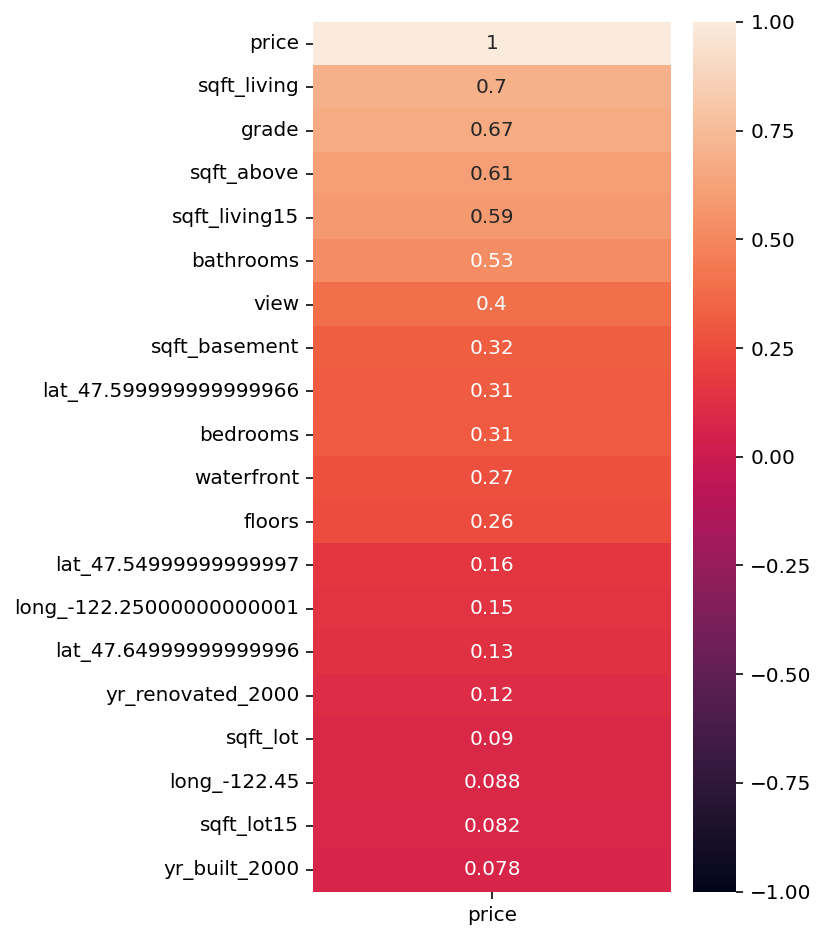

In [ ]:
plt.figure(figsize=(4, 8))
tempdf = df.corr()[['price']].sort_values('price', ascending=False).iloc[:20, :]
sns.heatmap(tempdf, annot=True, vmin=-1, vmax=1)


La característica más correlacionada es la superficie cuadrada, que se espera, las casas más grandes suelen ser más caras. Mirando la lista, las características tienen sentido. 

## Modelo de regresión
Creamos nuestros segmentos de entrenamiento y prueba de los datos y aplicamos un modelo de regresión lineal con mean_squared_error como funcion de perdida.

In [ ]:
X = df.drop(['price'], axis=1).values
y = df['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# outlier sanitization of the training set
factor = 5
y_train[np.abs(y_train - y_train.mean()) > (factor * y_train.std())] = y_train.mean() + factor*y_train.std()

# scale the price
ss_price = StandardScaler()
y_train = ss_price.fit_transform(y_train.reshape(-1,1))
y_test = ss_price.transform(y_test.reshape(-1,1))

(17290, 96) (17290,) (4323, 96) (4323,)


<Figure size 576x432 with 0 Axes>

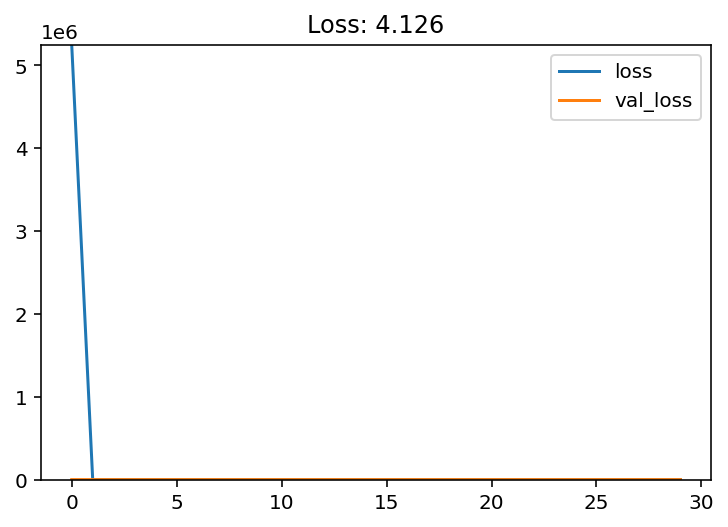

In [ ]:
linr_model = Sequential()
linr_model.add(Dense(1, input_shape=(X.shape[1],)))

linr_model.compile('adam', 'mean_squared_error')

linr_history = linr_model.fit(X_train.astype(np.float32), y_train.astype(np.float32), epochs=30, verbose=0, validation_split=0.2)
plot_loss(linr_history)

In [ ]:
linr_model.evaluate(X_test.astype(np.float32), y_test.astype(np.float32), verbose=0)

2.990330696105957

La pérdida disminuye en el primer par de épocas y luego se estabiliza. Es probable que no tengamos la capacidad adecuada, lo que significa que nuestro modelo no tiene suficiente capacidad y necesitamos un modelo más complejo.

Y las siguientes son las 10 características principales con los pesos más altos.

In [ ]:
# weights data frame
linr_wdf = pd.DataFrame(linr_model.get_weights()[0].T, 
                      columns=df.drop(['price'], axis=1).columns).T.sort_values(0, ascending=False)
linr_wdf.columns = ['feature_weight']
linr_wdf.iloc[:20,:]


,feature_weight
waterfront,0.44
yr_renovated_1930,0.44
yr_built_1930,0.40
yr_built_1920,0.40
lat_47.599999999999966,0.38
yr_built_1900,0.36
yr_renovated_1990,0.36
yr_built_1940,0.31
yr_renovated_-10,0.31
lat_47.64999999999996,0.31


##Modelo ANN
Construimos un modelo ANN para volverlo un modelo profundo. Agregamos nuevas capas con activación relu. La trama de pérdida parece interesante ahora. La pérdida de error de entrenamiento todavía parece estar disminuyendo, pero el error de validación comienza a aumentar después de la quinta época. Claramente nos estamos sobreajustando . La ANN está memorizando los datos de entrenamiento, y esto está reduciendo su capacidad de generalización en el conjunto de validación.

<Figure size 576x432 with 0 Axes>

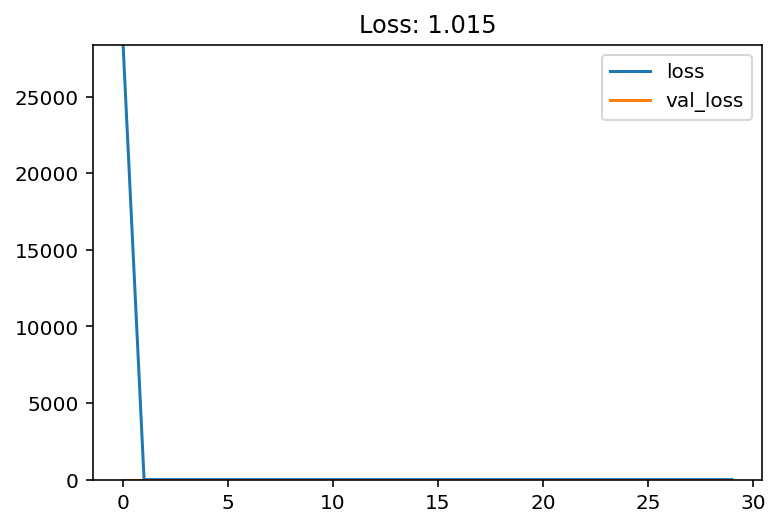

In [ ]:
deep_model = Sequential()
deep_model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
deep_model.add(Dense(16, activation='relu'))
deep_model.add(Dense(8, activation='relu'))
deep_model.add(Dense(1))

deep_model.compile('adam', 'mean_squared_error')

# early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
deep_history = deep_model.fit(X_train.astype(np.float32), y_train.astype(np.float32), epochs=30, verbose=0, validation_split=0.2)
#                               callbacks=[early_stop])
plot_loss(deep_history)

##Parada anticipada
Solucionamos el sobreajuste de la red neuronal con una parada anticipada deteniendo el entrenamiento antes de que la pérdida de entrenamiento se estanque. Solo modificamos la llamada a la función de ajuste, si no hay mejora para la pérdida de validación durante 2 épocas, detenemos el entrenamiento.

Epoch 8: early stopping


<Figure size 576x432 with 0 Axes>

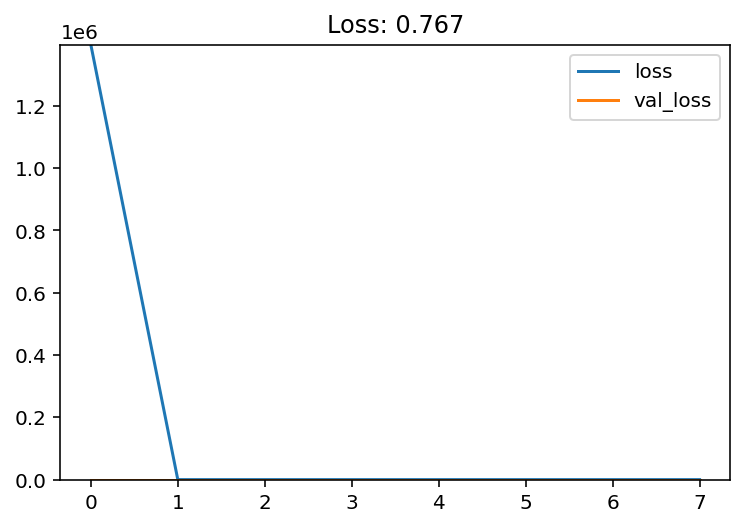

In [ ]:
# with early stopping
deep_model = Sequential()
deep_model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
deep_model.add(Dense(16, activation='relu'))
deep_model.add(Dense(8, activation='relu'))
deep_model.add(Dense(1))

deep_model.compile('adam', 'mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
deep_history = deep_model.fit(X_train.astype(np.float32), y_train.astype(np.float32), epochs=30, verbose=0, validation_split=0.2,
                              callbacks=[early_stop])
plot_loss(deep_history)

In [ ]:
deep_model.evaluate(X_test.astype(np.float32), y_test.astype(np.float32), verbose=0)

0.9771707057952881

Hacemos una comparación entre la regresión lineal y la regresión profunda. Obtuvimos una mejora con el modelo ANN sobre el modelo lineal.

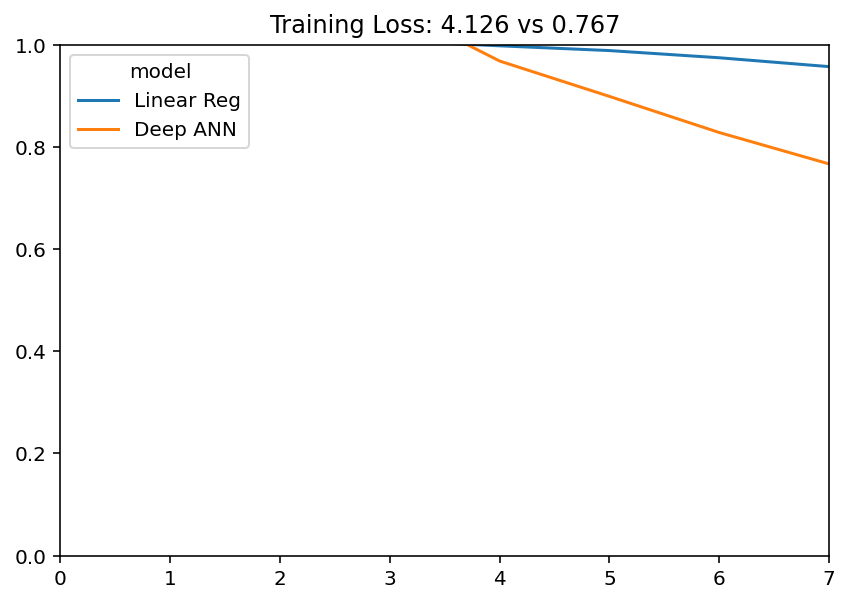

In [ ]:
plot_compare_histories([linr_history, deep_history], ['Linear Reg', 'Deep ANN'], plot_accuracy=False)

Hacemos una comparación final, la diferencia de valor en dólares entre el precio predicho del modelo y el precio real.

In [ ]:
def output_dollars(num):
    return '$'+str("{:,}".format(int(num)))

print('Average house price:', output_dollars(rawdf['price'].mean()))

real_prices = ss_price.inverse_transform(y_test)

# print('Training set house price:', np.mean(ss_price.inverse_transform(y_train)))

train_prices = ss_price.inverse_transform(y_train)
dumb_prices = np.zeros(real_prices.shape)
dumb_prices.fill(train_prices.mean())
dumb_error = mean_absolute_error(real_prices, dumb_prices)
print('Dumb model error:', output_dollars(dumb_error))

linr_predictions = linr_model.predict(X_test.astype(np.float32)).ravel()
linr_prices = ss_price.inverse_transform(linr_predictions.reshape(-1,1))
linr_error = mean_absolute_error(real_prices, linr_prices)
print('Linear model error:', output_dollars(linr_error))

deep_predictions = deep_model.predict(X_test.astype(np.float32)).ravel()
deep_prices = ss_price.inverse_transform(deep_predictions.reshape(-1,1))
deep_error = mean_absolute_error(real_prices, deep_prices)
print('Deep model error:', output_dollars(deep_error))

tdf = pd.DataFrame([['Naive Model', output_dollars(dumb_error)], 
                    ['Linear Regression', output_dollars(linr_error)], 
                    ['Deep ANN', output_dollars(deep_error)]], 
                   columns=['Model', 'Price Error'])
tdf

Average house price: $540,088
Dumb model error: $229,981
136/136 [==============================] - 0s 1ms/step
Linear model error: $549,898
136/136 [==============================] - 0s 2ms/step
Deep model error: $220,159


,Model,Price Error
0,Naive Model,"$229,981"
1,Linear Regression,"$549,898"
2,Deep ANN,"$220,159"


In [ ]:
print(r2_score(real_prices, dumb_prices), r2_score(real_prices, linr_prices), r2_score(real_prices, deep_prices))

-0.0006994565105877815 -1.8584981322535374 0.06590723243391372


In [ ]:
X=range(30)
y=range(30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train)
print(X_test)

[4, 19, 0, 11, 28, 21, 3, 1, 16, 20, 24, 8, 25, 29, 17, 10, 9, 26, 15, 27, 18]
[2, 14, 5, 13, 22, 6, 12, 7, 23]
